# <center><b>Music Information Retrieval</b></center>
## <center>UPF - MTG</center>
## <center>Sound classification - shallow pipeline</center>


### About

We will explore sound classification addressing the task of [Mridangam](https://en.wikipedia.org/wiki/Mridangam) stroke type classification. 

**Note**: *this notebook is based on Marius Miron class materials and in a similar notebook available in*
[github.com/MTG/MIRCourse](https://github.com/MTG/MIRCourse/)

### How to run the notebook
You can download the notebook and run it locally in your computer.

You can also run it in Google Colab by using the following link.

<table align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/mrocamora/mir_course/blob/main/notebooks/MIR_course-sound_classification_shallow_pipeline.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Setup Environment

### Install neccessary dependencies

In [ ]:
# install required packages
!pip install essentia
!pip install mirdata
!pip install pandas

# TODO check incase you are on colab and need to install some more below


# missing deps locally
!pip install numpy
!pip install matplotlib
!pip install seaborn

# optional if downlaoding features instead of calculating them
!pip install wget

### Import packages

In [176]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mirdata
import essentia.standard as ess

#optional import
import wget

# For playing audio in the notebook
from IPython.display import Audio

## Data Processing

We initialize the [Mridangam stroke dataset](https://mirdata.readthedocs.io/en/latest/source/mirdata.html#module-mirdata.datasets.mridangam_stroke), a collection of 7162 audio examples of individual strokes of the [Mridangam](https://en.wikipedia.org/wiki/Mridangam) in various tonics. The dataset comprises of 10 different strokes played on Mridangams with 6 different tonic values. 

In this experiment we predict 10 stroke classes. 

### Download and validate the data

In [ ]:
mridangam = mirdata.initialize("mridangam_stroke")

# mridangam.download()
mridangam.validate()

### Inspect the data

In [178]:
mridangam_ids = mridangam.track_ids  # Load Mridangam IDs
mridangam_data = mridangam.load_tracks()  # Load Mridangam data

mridangam_data[mridangam_ids[0]]  # Visualize a single track

Audio(mridangam_data[mridangam_ids[0]].audio_path) # Listen to one of the audio files

In [179]:
# Get complete list of different strokes
stroke_names = []
for i in mridangam_ids:
    stroke_names.append(mridangam_data[i].stroke_name)
stroke_names = np.unique(stroke_names)

print(stroke_names)

['bheem' 'cha' 'dheem' 'dhin' 'num' 'ta' 'tha' 'tham' 'thi' 'thom']


In [180]:
# You can create a dictionary using stroke type as keys
stroke_dict = {item: [] for item in stroke_names}
for i in mridangam_ids:
    stroke_dict[mridangam_data[i].stroke_name].append(mridangam_data[i].audio_path)

# Have a look at the first 10 audio paths for 'cha' stroke
stroke_dict['cha'][:10]

['/home/am/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224035__akshaylaya__cha-b-001.wav',
 '/home/am/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224036__akshaylaya__cha-b-002.wav',
 '/home/am/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224037__akshaylaya__cha-b-003.wav',
 '/home/am/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224038__akshaylaya__cha-b-004.wav',
 '/home/am/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224039__akshaylaya__cha-b-005.wav',
 '/home/am/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224040__akshaylaya__cha-b-006.wav',
 '/home/am/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224041__akshaylaya__cha-b-007.wav',
 '/home/am/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224042__akshaylaya__cha-b-008.wav',
 '/home/am/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224043__akshaylaya__cha-b-009.wav',
 '/home/am/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/B/224044__akshaylaya__cha-b-010.wav']

Plot waveforms of random samples of each stroke type...


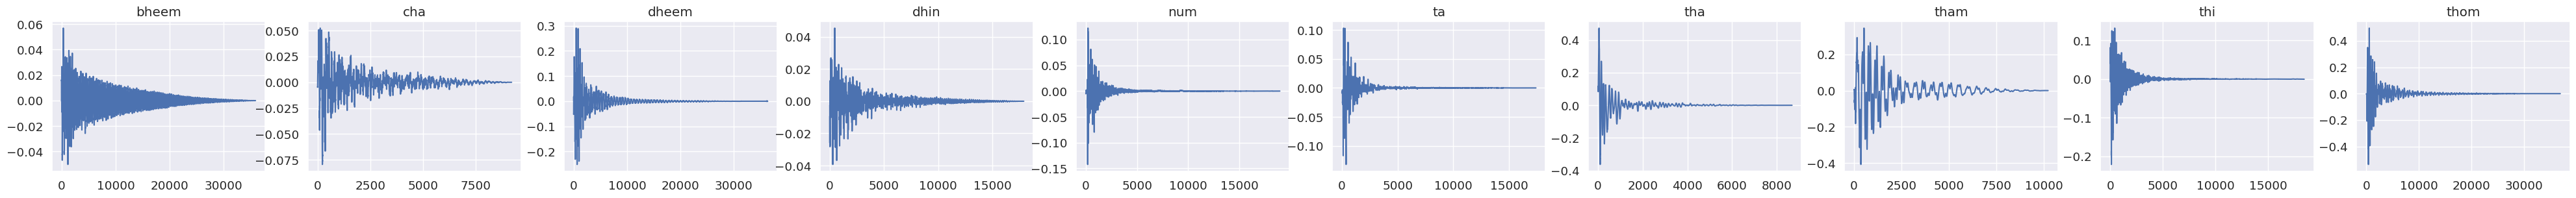

In [181]:
# Raw-data preprocess analysis parameters
_, fs = mridangam_data[mridangam_ids[0]].audio

num_strokes = len(stroke_dict.keys())
print("Plot waveforms of random samples of each stroke type...")
plt.figure(1, figsize=(5 * num_strokes, 3))
file_ind_inlist = 0 # 0: let's take the first file in the list for sample plots
for i, stroke in enumerate(stroke_dict.keys()):
    sample_file = stroke_dict[stroke][file_ind_inlist]
    x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
    
    plt.subplot(1,num_strokes,(i+1))
    plt.plot(x)
    plt.title(stroke)

### Data preprocessing

- While common preprocessing steps (such as amplitude normalisation) exist, there is often some dataset and task specific preprocessing tasks required for grouping, cleaning, and format change. 
- We would like to investigate the option of splitting the strokes using a fixed energy threshold (which would help us ignore the silence regions). Let's define a function to perform this operation and visualize some samples to observe the effectiveness of it.
- We will keep both the original and segmented data so as to **evaluate the effect of our pre-processing on model performance**.

In [182]:
# Lets define some parameters we will use for fixed energy threshold based segmentation preprocessing approach

# Raw-data preprocess analysis parameters
windowSize = 1024
hopSize = 512
NRG_threshold_ratio = 0.005 # Threshold expressed as ratio with respect to the maximum value

# Let's put in a container to be able to use as a single argument in function calls
params = {"fs":fs, "windowSize":windowSize, "hopSize":hopSize, "NRG_threshold_ratio": NRG_threshold_ratio}

In [183]:
# Define function to detect segments based on fixed energy threshold

def find_energy_based_boundaries(filename, params):
    """
    Detects segment boundaries in an audio file based on a fixed energy threshold.

    Args:
        filename (str): Path to the audio file.
        params (dict): Dictionary containing analysis parameters:
            - 'fs': Sample rate
            - 'windowSize': Frame size for analysis
            - 'hopSize': Hop size between frames
            - 'NRG_threshold_ratio': Energy threshold ratio (0-1) for detecting segments

    Returns:
        tuple: (x, NRG, split_decision_func, start_indexes, stop_indexes)
            - x (np.ndarray): Loaded audio signal
            - NRG (np.ndarray): Normalized energy curve
            - split_decision_func (np.ndarray): Binary mask indicating high-energy frames
            - start_indexes (np.ndarray): Start sample indexes of detected segments
            - stop_indexes (np.ndarray): Stop sample indexes of detected segments
    """
    #Unpacking parameters
    fs = params["fs"]
    windowSize = params["windowSize"]
    hopSize = params["hopSize"]
    NRG_threshold_ratio = params["NRG_threshold_ratio"]

    #Loading audio
    x = ess.MonoLoader(filename = filename, sampleRate = fs)()
    NRG = [];
    
    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
        NRG.append(ess.Energy()(frame))
    NRG = np.array(NRG)
    NRG = NRG / np.max(NRG)
    
    #Applying energy threshold to decide wave split boundaries
    split_decision_func = np.zeros_like(NRG)
    split_decision_func[NRG > NRG_threshold_ratio] = 1
    
    #Setting segment boundaries
    #Inserting a zero at the beginning since we will decide the transitions using a diff function
    split_decision_func = np.insert(split_decision_func, 0, 0)
    diff_split_decision = np.diff(split_decision_func)
    #Start indexes: transition from 0 to 1
    start_indexes = np.nonzero(diff_split_decision > 0)[0] * hopSize
    #Stop indexes: transition from 1 to 0
    stop_indexes = np.nonzero(diff_split_decision < 0)[0] * hopSize
    
    return (x, NRG, split_decision_func, start_indexes, stop_indexes)

Sample plots for waveform versus energy and splits based on energy threshold


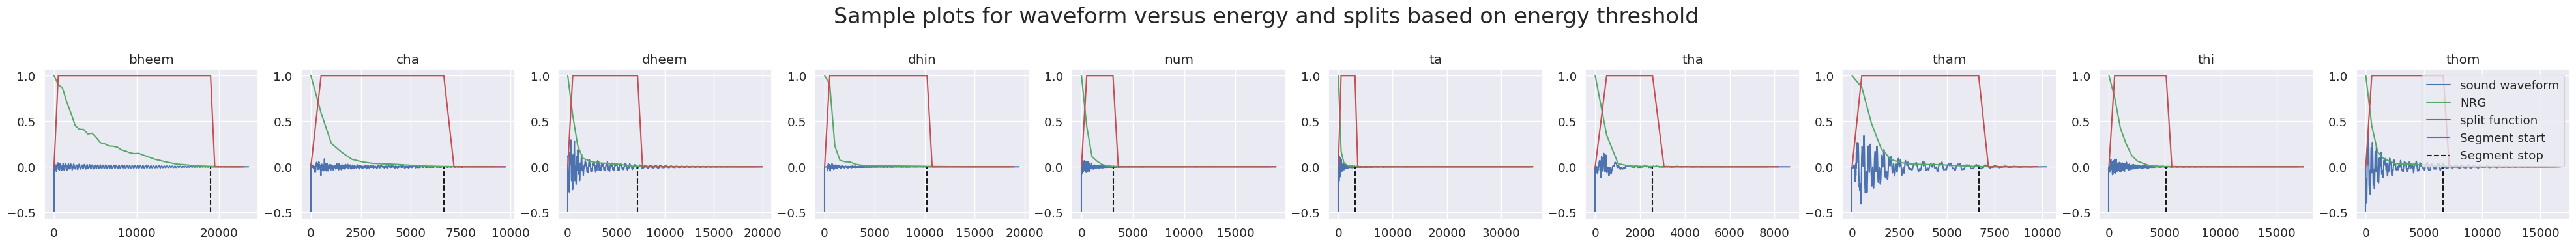

In [184]:
# Let's visualize some sample plots to see how well the fixed energy threshold based segmentation is working

num_strokes = len(stroke_names)
print("Sample plots for waveform versus energy and splits based on energy threshold")

file_indexes = [1]
for file_ind_inlist in file_indexes:
    plt.figure(file_ind_inlist, figsize=(5 * num_strokes, 3))
    plt.suptitle("Sample plots for waveform versus energy and splits based on energy threshold", fontsize=24, y=1.2)  # Move the main header up
    for i, stroke in enumerate(stroke_dict.keys()):
        sample_file = stroke_dict[stroke][file_ind_inlist]
        (x, NRG, split_decision_func, start_indexes, stop_indexes) = find_energy_based_boundaries(sample_file, params)
        #Plotting functions for checking the split decisions
        plt.subplot(1,num_strokes,(i+1))
        plt.title(stroke)
        plt.plot(x, label = 'sound waveform')
        plt.plot(np.arange(NRG.size) * hopSize, NRG, 'g', label = 'NRG')
        plt.plot(np.arange(split_decision_func.size) * hopSize, split_decision_func,'r', label = 'split function')
        plt.vlines(start_indexes, ymin = -0.5, ymax = 0, colors='b', linestyles='solid', label='Segment start')
        plt.vlines(stop_indexes, ymin = -0.5, ymax = 0, colors='k', linestyles='dashed', label='Segment stop')

plt.legend(loc="best");


In [185]:
def segment_and_save_files(stroke_dict, fs, params, main_data_dir='sample_data', segment_folder='segments'):
    """
    Segments audio files using split_file and saves segments as .wav files.

    Args:
        stroke_dict: dict mapping stroke names to lists of audio file paths
        fs: sample rate
        params: dict of parameters for split_file
        main_data_dir: main directory to save data
        segment_folder: subfolder for segments

    Returns:
        segment_files: list of saved segment file paths
    """
    main_data_dir = main_data_dir
    if not os.path.exists(main_data_dir): #creating the directory
        os.mkdir(main_data_dir)
    segments_dir = os.path.join(main_data_dir, segment_folder)
    if not os.path.exists(segments_dir): #creating the directory
        os.mkdir(segments_dir)

    segment_files = []
    for stroke, files in stroke_dict.items():
        for sample_file in files:
            #Get file id
            stroke_id =  sample_file.split('__')[-1].split('.')[0]
            # x = ess.MonoLoader(filename = sample_file, sampleRate = fs)() # Don't need to load this it gets returned by split_file
            (x, NRG, split_decision_func, start_indexes, stop_indexes) = find_energy_based_boundaries(sample_file, params)
            #Croping segments
            for start, stop in zip(start_indexes, stop_indexes):
                x_seg = x[start: stop]
                #Final check for amplitude (to avoid silent segments selection due to noise in split function)
                if(np.max(np.abs(x_seg)) > 0.05):
                    #Amplitude normalisation
                    x_seg = x_seg / np.max(np.abs(x_seg))
                    filename = os.path.join(segments_dir, stroke_id + '.wav')
                    ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(x_seg)
                    segment_files.append(filename)

    print(len(segment_files),'segment files created')
    return segment_files

In [ ]:
# Lets now call the function to segment our data

# Using stroke_dict as we defined earlier in the Inspect data section
segment_files = segment_and_save_files(stroke_dict, fs, params, main_data_dir='sample_data', segment_folder='segments')

# Essentia will log out some messages but this should not be an issue unless you see it is an error.

In [187]:
print(len(segment_files), 'segment files created.')

6854 segment files created.


In [ ]:
def get_segment_files_from_folder(folder_path):
    """
    Returns a list of full paths to .wav files in the given folder.

    Args:
        folder_path (str): Path to the folder containing segmented files.

    Returns:
        list: List of full file paths to .wav files.
    """
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.wav')]

In [189]:
segments_dir = 'sample_data/segments'
segment_files = get_segment_files_from_folder(segments_dir)
print(f"Found {len(segment_files)} segment files.")

Found 6853 segment files.


In [ ]:
#If required, you can use this cell to delete all files in a given folder
def delete_files_in_dir(dir_name):
    '''Deleting all files in a directory
    '''
    for root, dirs, files in os.walk(dir_name):
        for file in files:
            file_name = os.path.join(root,file)
            os.remove(file_name);print(file_name, 'removed');

# delete_files_in_dir(segments_dir)

In [191]:
# get the unsegmented files too
normal_dir = 'sample_data/normal'
normal_files = get_segment_files_from_folder(normal_dir)
print(f"Found {len(segment_files)} normal files.")

Found 6853 normal files.


## Feature extraction

Let's compute a list of common features for each of the files and form a data frame including features and categories. We will be using the [MusicExtractor function of Essentia](https://essentia.upf.edu/documentation/reference/std_MusicExtractor.html) that would compute a large number of features commonly used in MIR literature. 

Essentia-MusicExtractor extracts a large number of features. For simplicity, let's only keep low-level descriptors which are represented with a single scalar value as our feature set and discard other features.

### Choose the features to use

In [8]:
# Print descriptors to be considered
features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(mridangam_data['224030'].audio_path)

scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

[   INFO   ] MusicExtractor: Read metadata
[   INFO   ] MusicExtractor: Compute md5 audio hash, codec, length, and EBU 128 loudness
[   INFO   ] MusicExtractor: Replay gain
[   INFO   ] MusicExtractor: Compute audio features
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] FrameCutter: dropping silent frame
[   INFO   ] MusicExtractor: Compute aggregation
[   INFO   ] All done


In [172]:
# TODO Pick a subset of features to be used?


### Calculate the features

We want to calculate the features from the list of audio files we have and then save this data in a CSV file to reuse later.

⚠️ Calculating features on so many files can take quite some time on a typical personal computer or colab session. On a typical laptop it takes 10-15 minutes to calculate. You may **skip this step** and download pre-computed features if you wish.

In [ ]:
# optionally download pre-computed features instead of calculating them

data_file = 'mridangam_stroke_features.csv'
wget.download('https://github.com/mrocamora/mir_course/blob/main/data/mridangam_stroke_features.csv?raw=true')

In [53]:
# Function to extract features and write to CSV

def extract_features_to_csv(
    file_list, scalar_lowlevel_descriptors, output_csv
):
    """
    Extract features from a list of audio files and write them to a CSV file.

    Args:
        file_list: list of audio file paths
        scalar_lowlevel_descriptors: list of feature names to extract
        output_csv: output CSV file path
    """
    import essentia.standard as ess

    file_count = 0
    with open(output_csv, 'w') as writer:
        # adding column names as the first line in csv
        line2write = ','.join(scalar_lowlevel_descriptors + ['stroke']).replace('lowlevel.', '') + '\n'
        writer.write(line2write)
        for filename in file_list:
            file_count += 1
            if file_count % 20 == 0:  # print name of a file every 20 files
                print(file_count, "files processed, current file: ", filename)

            # Compute and write features for file
            features, features_frames = ess.MusicExtractor(
                lowlevelSilentFrames='drop',
                lowlevelFrameSize=2048,
                lowlevelHopSize=1024,
                lowlevelStats=['mean', 'stdev']
            )(filename)
            selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
           
            label = filename.split('/')[-1].split('.')[0].split('-')[0]
            line2write = str(selected_features)[1:-1] + ',' + label + '\n'
            writer.write(line2write)
    print("A total of", file_count, "files processed")

In [ ]:
# Example usage for segmented files:
extract_features_to_csv(segment_files, scalar_lowlevel_descriptors, 'segmented_features.csv')

In [ ]:
# Example usage for segmented files:
extract_features_to_csv(normal_files, scalar_lowlevel_descriptors, 'normal_features.csv')

In [ ]:
#If data file already exists, skip feature extraction
if not os.path.exists(data_file):
	extract_features_to_csv()

## Prepare Train, test and validation data

Now we have our features, we need to ensure we split the data properly into train test and validation sets.

In [219]:
segmented_data_file = 'segmented_features.csv'

normal_data_file = 'normal_features.csv'

Its important to inspect the distribution of the different strokes, since we want the dataset to be balanced.

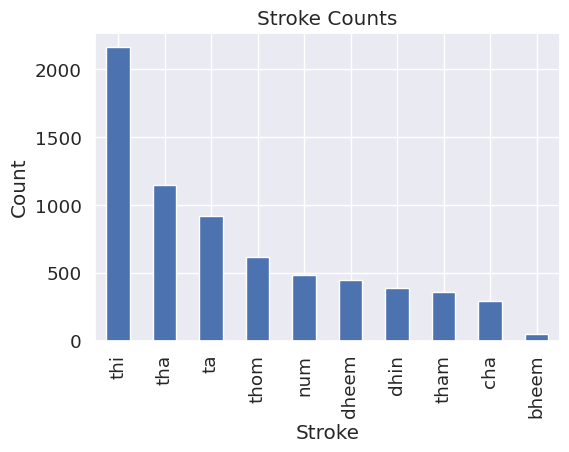

In [220]:
# Load data
data_test = pd.read_csv(segmented_data_file)

# Count values
counts = data_test.stroke.value_counts()

# Plot
counts.plot(kind='bar', figsize=(6, 4))
plt.title("Stroke Counts")
plt.xlabel("Stroke")
plt.ylabel("Count")
plt.show()

We see that cha is not there is quite a range in the frequencies of each stroke class. We will try downsampling to the number of cha cases, leaving bheem as it is since there are so few.

In [194]:
def downsample_strokes_rebalance(data, exception_classes=None, rebalance_class='cha', random_state=42):
    """
    Rebalances stroke classes by downsampling so that all classes 
    (except the exception_classes) have the same number of samples 
    as rebalance_class.
    
    Parameters:
        data (pd.DataFrame): Input dataframe with a 'stroke' column.
        exception_classes (list[str] or None): Classes not to be downsampled.
        rebalance_class (str): Class used to determine the target sample size.
        random_state (int): Random seed for reproducibility.
    
    Returns:
        pd.DataFrame: Balanced dataframe.
    """
    if exception_classes is None:
        exception_classes = []
    elif isinstance(exception_classes, str):
        # Allow a single class to be passed as a string
        exception_classes = [exception_classes]

    # Target sample size
    target_size = data.stroke.value_counts()[rebalance_class]

    sampled_data = []

    # Downsample all classes except exceptions
    for stroke in data.stroke.unique():
        if stroke in exception_classes:
            sampled_data.append(data[data.stroke == stroke])  # keep full
        else:
            sampled_data.append(
                data[data.stroke == stroke].sample(n=target_size, random_state=random_state)
            )

    # Merge all
    return pd.concat(sampled_data, ignore_index=True)

Data preperation pipeline for training, validation and testing

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

def prepare_data_for_training(data_file, test_size=0.2, val_size=0.1, random_state=42):
    # Read CSV
    data = pd.read_csv(data_file)

    # Balance the dataset
    data_balanced = downsample_strokes_rebalance(
        data, 
        exception_classes=['bheem'], 
        rebalance_class='cha',
        random_state=random_state
    )

    print("Stroke counts after balancing:\n", data_balanced.stroke.value_counts())

    # Separate features (first 84 cols) and labels
    X = data_balanced.iloc[:, :-1].values   # all columns except last
    y = data_balanced.iloc[:, -1].values    # last column (stroke)

    # Normalize features
    scaler = preprocessing.MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Encode labels (string → numeric)
    label_encoder = preprocessing.LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # First split: train vs temp (test+val)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_scaled, y_encoded, test_size=(test_size + val_size), random_state=random_state, stratify=y_encoded
    )
    # Compute relative val size in temp
    val_ratio = val_size / (test_size + val_size)
    # Second split: temp → val and test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(1 - val_ratio), random_state=random_state, stratify=y_temp
    )

    return X_train, X_val, X_test, y_train, y_val, y_test, label_encoder


In [227]:
# Get our data ready for training!
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = prepare_data_for_training(segmented_data_file)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape, "Val shape:", X_val.shape)
print("Classes:", label_encoder.classes_)

Stroke counts after balancing:
 stroke
cha      294
dheem    294
tha      294
dhin     294
num      294
ta       294
thi      294
tham     294
thom     294
bheem     46
Name: count, dtype: int64
Train shape: (1884, 84) Test shape: (539, 84) Val shape: (269, 84)
Classes: ['bheem' 'cha' 'dheem' 'dhin' 'num' 'ta' 'tha' 'tham' 'thi' 'thom']


## Supervised learning approaches

We will compare [Support vector machines (SVM)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and a simple [MLP classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) neural network implemented using Sklearn on the Mridangam dataset.

In [228]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Train SVM
svm = SVC(gamma = 1 / (X_train.shape[-1] * X_train.var()), random_state=42)
svm.fit(X_train, y_train)
print("SVM results:\n", classification_report(y_test, svm.predict(X_test), target_names=label_encoder.classes_))

SVM results:
               precision    recall  f1-score   support

       bheem       1.00      1.00      1.00         9
         cha       0.85      0.97      0.90        59
       dheem       0.91      0.86      0.88        58
        dhin       0.89      0.85      0.87        59
         num       0.93      0.95      0.94        59
          ta       0.97      0.95      0.96        59
         tha       0.95      0.98      0.97        59
        tham       0.91      0.85      0.88        59
         thi       0.90      0.88      0.89        59
        thom       0.93      0.95      0.94        59

    accuracy                           0.92       539
   macro avg       0.92      0.92      0.92       539
weighted avg       0.92      0.92      0.92       539



In [229]:
from sklearn.neural_network import MLPClassifier

# Train MLP
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
print("MLP results:\n", classification_report(y_test, mlp.predict(X_test), target_names=label_encoder.classes_))

MLP results:
               precision    recall  f1-score   support

       bheem       1.00      1.00      1.00         9
         cha       0.92      0.95      0.93        59
       dheem       0.95      0.91      0.93        58
        dhin       0.95      0.93      0.94        59
         num       0.92      0.95      0.93        59
          ta       0.98      0.97      0.97        59
         tha       0.97      0.98      0.97        59
        tham       0.88      0.90      0.89        59
         thi       0.93      0.92      0.92        59
        thom       0.97      0.95      0.96        59

    accuracy                           0.94       539
   macro avg       0.95      0.95      0.95       539
weighted avg       0.94      0.94      0.94       539



/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Test on normal data (remove and leave as optional?)



In [226]:
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = prepare_data_for_training(normal_data_file)

print("Results for normal unsegmented data")

svm = SVC(gamma = 1 / (X_train.shape[-1] * X_train.var()), random_state=42)
svm.fit(X_train, y_train)
print("SVM results:\n", classification_report(y_test, svm.predict(X_test), target_names=label_encoder.classes_))

mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
print("MLP results:\n", classification_report(y_test, mlp.predict(X_test), target_names=label_encoder.classes_))

Stroke counts after balancing:
 stroke
ta       319
dheem    319
tha      319
thi      319
thom     319
num      319
dhin     319
tham     319
cha      319
bheem     49
Name: count, dtype: int64
Results for normal unsegmented data
SVM results:
               precision    recall  f1-score   support

       bheem       1.00      1.00      1.00         9
         cha       0.84      0.81      0.83        64
       dheem       0.84      0.80      0.82        64
        dhin       0.79      0.89      0.84        64
         num       0.82      0.84      0.83        64
          ta       0.85      0.88      0.86        64
         tha       0.96      0.84      0.90        64
        tham       0.87      0.75      0.81        64
         thi       0.71      0.77      0.74        64
        thom       0.88      0.95      0.92        64

    accuracy                           0.84       585
   macro avg       0.86      0.85      0.85       585
weighted avg       0.84      0.84      0.84       5

/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


We see that on the unsegmented data the performance of the SVM drops fairly significantly down to 84% accuracy from 92%.

As for the MLP it is less effected it is down to 92% accuracy vs 94% on the segmented data on the test set.

### Feature selection

In [215]:
# feature selection
from sklearn.feature_selection import SelectKBest, f_classif

def select_best_features(X_train, y_train, X_val, y_val, model, k_list):
    """
    Finds the best number of features for a given model using SelectKBest and validation accuracy.
    Returns the fitted selector and the best score.
    """
    best_score = 0
    best_k = None
    best_selector = None
    for k in k_list:
        selector = SelectKBest(f_classif, k=k)
        X_train_sel = selector.fit_transform(X_train, y_train)
        X_val_sel = selector.transform(X_val)
        model.fit(X_train_sel, y_train)
        score = model.score(X_val_sel, y_val)
        if score > best_score:
            best_score = score
            best_k = k
            best_selector = selector
    print(f"Best k: {best_k}, Validation accuracy: {best_score:.3f}")
    return best_selector, best_k, best_score

In [230]:
# Lets do our feature seleciton on the best performing data (segmented data) load it again.
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = prepare_data_for_training(segmented_data_file)

Stroke counts after balancing:
 stroke
cha      294
dheem    294
tha      294
dhin     294
num      294
ta       294
thi      294
tham     294
thom     294
bheem     46
Name: count, dtype: int64


In [231]:
# Remove features that have zero variance

from sklearn.feature_selection import VarianceThreshold

# Before removing constant features
n_features_before = X_train.shape[1]

# Remove constant features
vt = VarianceThreshold(threshold=0.0)
X_train = vt.fit_transform(X_train)
X_val = vt.transform(X_val)
X_test = vt.transform(X_test)

# After removing constant features
n_features_after = X_train.shape[1]

print(f"Removed {n_features_before - n_features_after} constant features.")


Removed 5 constant features.


In [232]:
from sklearn.svm import SVC
svm = SVC(random_state=42)
k_list = range(5, X_train.shape[1]+1, 1)
print(k_list)
svm_selector, svm_best_k, svm_best_score = select_best_features(X_train, y_train, X_val, y_val, svm, k_list)

range(5, 80)
Best k: 64, Validation accuracy: 0.907


In [ ]:
# Transform your data using the best selector
X_train_sel = svm_selector.transform(X_train)
X_val_sel = svm_selector.transform(X_val)
X_test_sel = svm_selector.transform(X_test)

# Retrain your model on the selected features (optionally on train+val)
svm_final = SVC(random_state=42)
svm_final.fit(X_train_sel, y_train)

# Evaluate on the test set
y_pred = svm_final.predict(X_test_sel)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

       bheem       1.00      1.00      1.00         9
         cha       0.89      0.97      0.93        59
       dheem       0.90      0.91      0.91        58
        dhin       0.95      0.90      0.92        59
         num       0.95      0.95      0.95        59
          ta       0.92      0.95      0.93        59
         tha       1.00      0.97      0.98        59
        tham       0.90      0.90      0.90        59
         thi       0.91      0.90      0.91        59
        thom       0.96      0.93      0.95        59

    accuracy                           0.93       539
   macro avg       0.94      0.94      0.94       539
weighted avg       0.93      0.93      0.93       539



In [235]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X_train_sel, y_train)
print("MLP results:\n", classification_report(y_test, mlp.predict(X_test_sel), target_names=label_encoder.classes_))

MLP results:
               precision    recall  f1-score   support

       bheem       1.00      1.00      1.00         9
         cha       0.86      1.00      0.92        59
       dheem       0.95      0.93      0.94        58
        dhin       1.00      0.93      0.96        59
         num       0.92      0.93      0.92        59
          ta       0.92      0.95      0.93        59
         tha       1.00      0.98      0.99        59
        tham       0.93      0.88      0.90        59
         thi       0.93      0.88      0.90        59
        thom       0.98      0.97      0.97        59

    accuracy                           0.94       539
   macro avg       0.95      0.95      0.95       539
weighted avg       0.94      0.94      0.94       539



/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Selecting features in this way does not have much effect on performance on the test data. However refining to a shorter number of features is useful in that we can train smaller models and if re-calculating features save on computation time in the future.

### Comparing Results

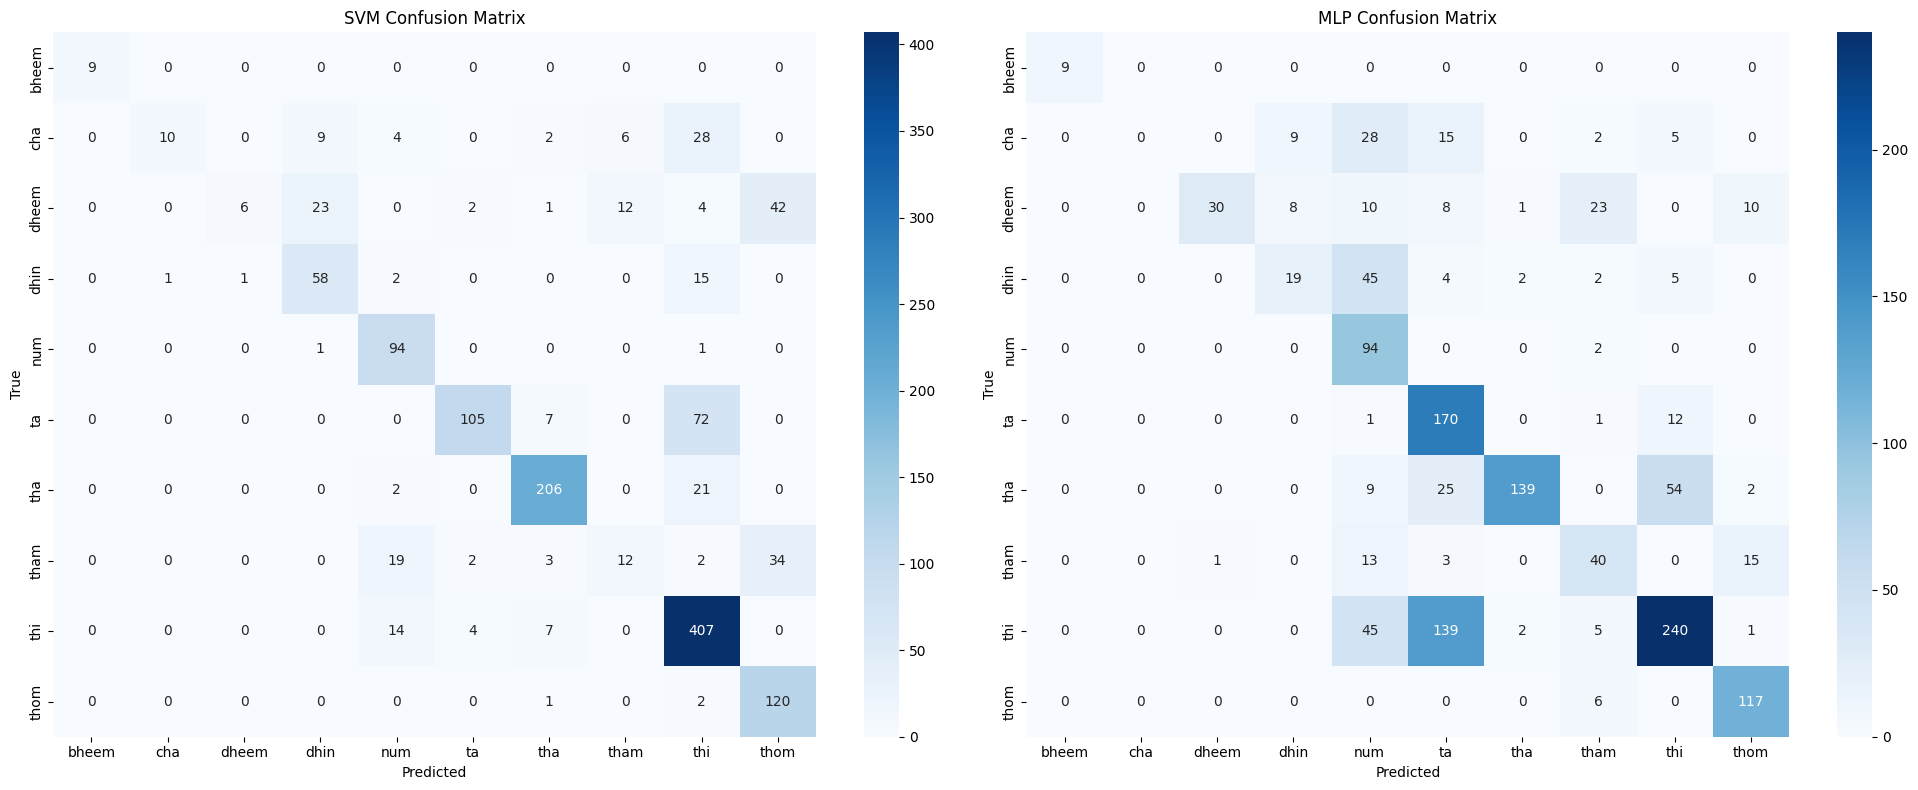

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions
svm_pred = svm.predict(X_test)
mlp_pred = mlp.predict(X_test)

# Create confusion matrices
svm_cm = confusion_matrix(y_test, svm_pred)
mlp_cm = confusion_matrix(y_test, mlp_pred)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

# Plot SVM confusion matrix
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
			yticklabels=label_encoder.classes_, ax=ax1)
ax1.set_title('SVM Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

# Plot MLP confusion matrix
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
			yticklabels=label_encoder.classes_, ax=ax2)
ax2.set_title('MLP Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

plt.tight_layout()
plt.show()

How might you understand these results?

### Supervised learning approach with Neural Network (pytorch version, maybe too much for this notebook?)

In [ ]:
import torch
import pytorch_lightning as pl
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report

# Define Mridangam Dataset
class MridangamDataset(Dataset):
	def __init__(self, X, y):
		self.X = torch.FloatTensor(X)
		self.y = torch.LongTensor(y)
		
	def __len__(self):
		return len(self.y)
	
	def __getitem__(self, idx):
		return self.X[idx], self.y[idx]

# Lightning Module
class MridangamClassifier(pl.LightningModule):
	def __init__(self, input_dim, num_classes, hidden_dim=100):
		super().__init__()
		self.model = nn.Sequential(
			nn.Linear(input_dim, hidden_dim),
			nn.ReLU(),
			nn.Dropout(0.2),
			nn.Linear(hidden_dim, num_classes)
		)
		self.criterion = nn.CrossEntropyLoss()
		
	def forward(self, x):
		return self.model(x)
	
	def training_step(self, batch, batch_idx):
		x, y = batch
		logits = self(x)
		loss = self.criterion(logits, y)
		self.log('train_loss', loss)
		return loss
	
	def validation_step(self, batch, batch_idx):
		x, y = batch
		logits = self(x)
		loss = self.criterion(logits, y)
		preds = torch.argmax(logits, dim=1)
		acc = (preds == y).float().mean()
		self.log('val_loss', loss)
		self.log('val_acc', acc)
		return loss
	
	def configure_optimizers(self):
		return torch.optim.Adam(self.parameters(), lr=0.001)

# Data preparation and training
X_train, X_test, y_train, y_test, label_encoder = prepare_data_for_training(segmented_data_file)

# Create datasets
train_dataset = MridangamDataset(X_train, y_train)
val_dataset = MridangamDataset(X_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Initialize model
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))
model = MridangamClassifier(input_dim, num_classes)

# Initialize trainer
trainer = pl.Trainer(
	max_epochs=50,
	accelerator='auto',
	devices=1,
	enable_progress_bar=True
)

# Train model
trainer.fit(model, train_loader, val_loader)

# Get predictions on test set
model.eval()
with torch.no_grad():
	test_preds = model(torch.FloatTensor(X_test))
	test_preds = torch.argmax(test_preds, dim=1).numpy()

# Print classification report
print("PyTorch Lightning MLP results:\n", 
		classification_report(y_test, test_preds, target_names=label_encoder.classes_))

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


Stroke counts after balancing:
 stroke
cha      294
dheem    294
tha      294
dhin     294
num      294
ta       294
thi      294
tham     294
thom     294
bheem     46
Name: count, dtype: int64


2025-10-03 09:22:05.974926: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-03 09:22:05.987932: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-03 09:22:06.421774: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-03 09:22:10.354649: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation or

/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 172/172 [00:01<00:00, 161.30it/s, v_num=0]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 172/172 [00:01<00:00, 160.58it/s, v_num=0]
PyTorch Lightning MLP results:
               precision    recall  f1-score   support

       bheem       1.00      1.00      1.00         9
         cha       0.85      0.86      0.86        59
       dheem       0.88      0.91      0.90        90
        dhin       0.88      0.87      0.88        77
         num       0.94      0.97      0.95        96
          ta       0.90      0.90      0.90       184
         tha       0.97      0.97      0.97       229
        tham       0.91      0.83      0.87        72
         thi       0.94      0.94      0.94       432
        thom       0.98      0.97      0.98       123

    accuracy                           0.93      1371
   macro avg       0.92      0.92      0.92      1371
weighted avg       0.93      0.93      0.93      1371



## Questions

Ideas:

Why does segmentation not have much effect in the case of the MLP?
- The waveforms in the dataset are already pretty well trimmed. So we don't actually remove many cases where the trailing or preceding silence or noise would obscufate the data.

Can you downsample or upsample in a different way that improves performance? Evaluate the pros and cons of each approach.

Witht the approach taken using SelectKBest, can you explain why it decided to drop the features it did? Why do these features not help the models discriminate effectivley between classes? or did it make mistakes? Improvements to feature selection?

Can you tune the hyperparamters of the svm and mlp to improve performance?

Is there a upper threshold on performance for the current models used?

Analyse individual error cases, listen to them, analyse them and explain why the models predict these cases wrongly.